In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import utils
import unicodedata
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization,Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download("maxent_treebank_pos_tagger")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anilo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anilo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\anilo\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


True

# Sentiment Analysis on McDonald's Reviews with Doc2Vec and Neural Networks

In this jupyter notebook, our goal is do sentiment analys on mcdonald review datasets with DOC2VEC and Neural Networks.

---

## Part I: Groundwork and Basic LSTM

### Exploratory Data Analysis (EDA)
Before diving into sentiment analysis, let's familiarize ourselves with the dataset:
- **Basic Statistics**: Understand the distribution of sentiments. How balanced is our dataset?
- **Missing Values**: Are there any missing reviews or sentiments?
- **Review Length Analysis**: Distribution of the review lengths can give insights about the data.

### Data Cleaning & Tokenization
A crucial step in NLP, let's get our data in shape:
- **Lowercasing**: Standardize the text by converting everything to lowercase.
- **Removing Special Characters**: Simplify the text.
- **Tokenization**: Break down reviews into individual words or tokens.

### Doc2Vec Embedding
Moving on from tokenization:
- **Model Creation**: Train a Doc2Vec model on our dataset.
- **Embedding Matrix**: Extract the learned word vectors to form our embedding matrix.

### LSTM Model
Laying down our foundational model:
- **LSTM Layer**: Leveraging Long Short-Term Memory units for sequence modeling.
- **Compilation and Training**: Using an appropriate optimizer, loss function, and performance metric.

---

## Part II: Enhancing the LSTM Model

With our basic model in place, let's try to enhance its performance:
- **Dropout Layer**: To prevent overfitting by dropping a fraction of the neurons.
- **Batch Normalization**: Helps in faster convergence and overall network training.
- **Adding More Layers**: Experimenting with depth to see if it enhances model capacity.

---

## Part III: Impact of Sequence Length

What happens when we modify the `MAX_SEQUENCE_LENGTH`?


---

## Part IV: Exploring Advanced Architectures

Let's experiment with a different neural network setup:
- **1D Convolutional Layer**: Effective in picking up local patterns within the sequence.
- **Bidirectional LSTM**: Captures patterns from both forward and backward directions.

---

## Part V: Doc2Vec Model Optimization

We want to optimize DOC2VEC model with grid search.


In [3]:
def evaluation_metrics(Y_test, preds):
    # Creating a confusion matrix
    cm = confusion_matrix(Y_test, preds)

    # Printing the classification report
    print(classification_report(Y_test, preds))

    # Printing the F1 Score
    print("F1 Score: ", f1_score(Y_test, preds, average='weighted'))
    
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
    plt.title('Confusion Matrix')
    plt.xlabel('Y predict')
    plt.ylabel('Y test')
    plt.show()
    

#  Part I

In [4]:
df = pd.read_csv(r'E:\NLP\Datasets\McDonald_s_Reviews.csv',engine='c', encoding='latin-1')

# EDA on Datasets

In [5]:
df

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star
...,...,...,...,...,...,...,...,...,...,...
33391,33392,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",4 years ago,They treated me very badly.,1 star
33392,33393,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,The service is very good,5 stars
33393,33394,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,To remove hunger is enough,4 stars
33394,33395,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,"It's good, but lately it has become very expen...",5 stars


In [6]:
for c in df:
    print(f'Number of {c} unique values: {df[c].nunique()}')

Number of reviewer_id unique values: 33396
Number of store_name unique values: 2
Number of category unique values: 1
Number of store_address unique values: 40
Number of latitude  unique values: 39
Number of longitude unique values: 39
Number of rating_count unique values: 51
Number of review_time unique values: 39
Number of review unique values: 22285
Number of rating unique values: 5


In [7]:
for c in df:
    print(f'Number of {c} NA values: {df[c].isna().sum()}')

Number of reviewer_id NA values: 0
Number of store_name NA values: 0
Number of category NA values: 0
Number of store_address NA values: 0
Number of latitude  NA values: 660
Number of longitude NA values: 660
Number of rating_count NA values: 0
Number of review_time NA values: 0
Number of review NA values: 0
Number of rating NA values: 0


In [8]:
star_mapping = {
    "1 star": 1, 
    "2 stars": 2, 
    "3 stars": 3, 
    "4 stars": 4, 
    "5 stars": 5,
}

df["rating"] = df["rating"].map(star_mapping)

In [9]:
def map_rating(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    elif rating in [4, 5]:
        return 'Positive'

df['Sentiment'] = df['rating'].apply(map_rating)
df

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,Sentiment
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1,Negative
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4,Positive
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1,Negative
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,Positive
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Negative
...,...,...,...,...,...,...,...,...,...,...,...
33391,33392,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",4 years ago,They treated me very badly.,1,Negative
33392,33393,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,The service is very good,5,Positive
33393,33394,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,To remove hunger is enough,4,Positive
33394,33395,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,"It's good, but lately it has become very expen...",5,Positive


**Class Distribution**

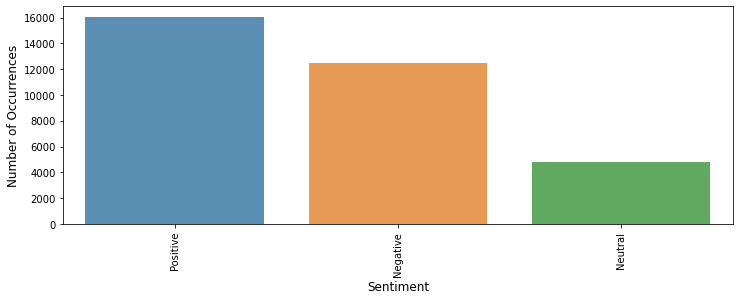

In [10]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()


**Text Length Analysis**

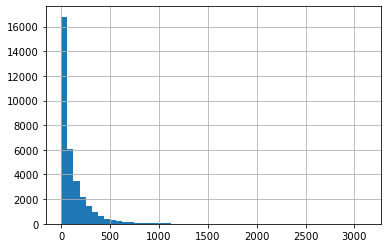

In [11]:
df['text_length'] = df['review'].apply(len)
df['text_length'].hist(bins=50)
plt.show()

**Word Frequency Analysis**

In [12]:
vectorizer = CountVectorizer(stop_words='english', max_features=100)
freqs = vectorizer.fit_transform(df['review'])
sum_words = freqs.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
print(words_freq[:10])


[('½ï', 78842), ('food', 7875), ('service', 6279), ('order', 6194), ('good', 5608), ('mcdonald', 4502), ('place', 3399), ('drive', 3292), ('fast', 2733), ('just', 2727)]


**N-gram Analysis**

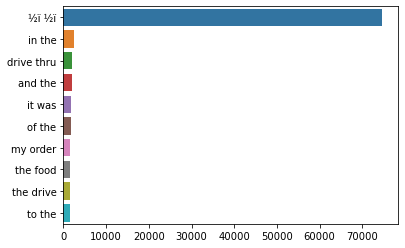

In [13]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df['review'],2)


**Sample Text Review**

In [14]:
def print_message(index):
    example = df[df.index == index][['review', 'Sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('review:', example[1])
print_message(150)

Went thru the drive thru, for breakfast. I like the Egg McMuffin meal, but that is about the only thing I'll eat off of their menu. My meal with a coke, ended up being wrong. They gave me a sausage biscuit and the coke was horrible. The line was so long, that I did not have time to wait, so I just threw it all away. I won't be coming back to this location.
review: Negative


**We Assume<br> 
{'Positive': 0,<br>'Neutral': 1,<br>'Negative':2<br>}**

In [15]:
sentiment  = {'Positive': 0,'Neutral': 1,'Negative':2} 

df.Sentiment = [sentiment[item] for item in df.Sentiment] 
df

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,Sentiment,text_length
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1,2,259
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4,0,237
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1,2,415
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,0,176
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1,2,312
...,...,...,...,...,...,...,...,...,...,...,...,...
33391,33392,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",4 years ago,They treated me very badly.,1,2,27
33392,33393,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,The service is very good,5,0,24
33393,33394,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,To remove hunger is enough,4,0,26
33394,33395,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,"It's good, but lately it has become very expen...",5,0,51


# Cleaning

**Remove punctuation and etc.**

In [16]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # removing HTML encoding such as '&amp', '<br>', etc.
    text = BeautifulSoup(text, "lxml").text

    # replacing URLs
    text = re.sub(r'http\S+|www.\S+', r'<URL>', text)
    
    # replacing encoded '\n' (new lines)
    text = re.sub(r'\n', r' ', text) 

    # replacing numbers
    text = re.sub(r'\d+', '', text)
    
    # replacing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # lowercasing
    text = text.lower()

    # removing 'x'
    text = text.replace('x', '')
    
    # encoding to ascii and decoding to remove non-ascii characters
    text = text.encode("ascii", "ignore").decode()

    # removing stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text
df['cleaned_review'] = df['review'].apply(clean_text)
df[['cleaned_review','review']]

,cleaned_review,review
0,look like someone spit food normal transaction...,Why does it look like someone spit on my food?...
1,itd mcdonalds far food atmosphere go staff mak...,It'd McDonalds. It is what it is as far as the...
2,made mobile order got speaker checked line mov...,Made a mobile order got to the speaker and che...
3,mc crispy chicken sandwich customer service qu...,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...
4,repeat order times drive thru still manage mes...,"I repeat my order 3 times in the drive thru, a..."
...,...,...
33391,treated badly,They treated me very badly.
33392,service good,The service is very good
33393,remove hunger enough,To remove hunger is enough
33394,good lately become epensive,"It's good, but lately it has become very expen..."


**Tokenizer with Lemmatization**

In [17]:
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            # skip if the word is less than two characters
            if len(word) < 2:
                continue

            # lemmatize the word
            word = lemmatizer.lemmatize(word)

            tokens.append(word)

    # remove leading/trailing white space
    tokens = [token.strip() for token in tokens]
    
    return tokens

df['review_token'] = df['cleaned_review'].apply(tokenizer)
df[['review_token','cleaned_review']]

,review_token,cleaned_review
0,"[look, like, someone, spit, food, normal, tran...",look like someone spit food normal transaction...
1,"[itd, mcdonalds, far, food, atmosphere, go, st...",itd mcdonalds far food atmosphere go staff mak...
2,"[made, mobile, order, got, speaker, checked, l...",made mobile order got speaker checked line mov...
3,"[mc, crispy, chicken, sandwich, customer, serv...",mc crispy chicken sandwich customer service qu...
4,"[repeat, order, time, drive, thru, still, mana...",repeat order times drive thru still manage mes...
...,...,...
33391,"[treated, badly]",treated badly
33392,"[service, good]",service good
33393,"[remove, hunger, enough]",remove hunger enough
33394,"[good, lately, become, epensive]",good lately become epensive


# DOC2VEC

**What is DOC2VEC ?**<br>
**-** Doc2Vec is an unsupervised algorithm that learns fixed-length feature vectors for paragraphs/documents/texts.Documents are represented in a continuous vector space where semantically similar items are closer to each other.there are two core training algorithms to consider:

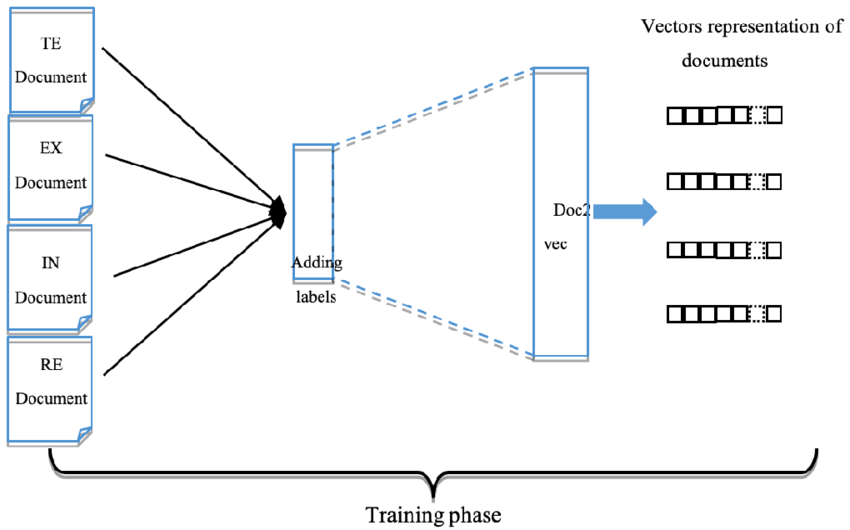

## 1. Distributed Memory (DM)

**Description**: Distributed Memory, abbreviated as DM, draws parallels with the Continuous Bag of Words (CBOW) mechanism in `Word2Vec`.

- **Operational Mechanism**:
    - It harmonizes the document's tag with the words within the document to anticipate the subsequent word in a specified window.
    - Notably, this model retains the sequence or order of the words.


## 2. Distributed Bag of Words (DBOW)

**Description**: In the realm of `Doc2Vec`, DBOW is synonymous with the Skip-gram model in `Word2Vec`.

- **Operational Mechanism**:
    - Contrary to utilizing words to predict an adjoining word, DBOW employs the document's tag to foretell the words encompassing the document.
    - Interestingly, in this approach, the sequence of words is not maintained.

In [18]:
train_tagged = df.apply(
    lambda r: TaggedDocument(words=(r['review_token']), tags=[r.Sentiment]), axis=1)

In [19]:
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['review_token'].values)
X = tokenizer.texts_to_sequences(df['review_token'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
print('Found %s unique tokens.' % len(X))

Shape of data tensor: (33396, 50)
Found 33396 unique tokens.


In [20]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 33396/33396 [00:00<00:00, 1337774.11it/s]


In [21]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 33396/33396 [00:00<00:00, 1761458.94it/s]


Wall time: 1min 41s


In [22]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [23]:
len(d2v_model.wv.key_to_index)

13772

In [24]:
d2v_model.wv.key_to_index.keys()

dict_keys(['food', 'order', 'service', 'mcdonalds', 'good', 'place', 'get', 'time', 'one', 'drive', 'fast', 'like', 'ecellent', 'staff', 'customer', 'go', 'great', 'always', 'people', 'fry', 'clean', 'minute', 'location', 'dont', 'got', 'thru', 'manager', 'employee', 'even', 'nice', 'never', 'back', 'ordered', 'wait', 'friendly', 'didnt', 'ever', 'bad', 'rude', 'went', 'would', 'line', 'slow', 'long', 'asked', 'worst', 'take', 'meal', 'said', 'wrong', 'really', 'coffee', 'hot', 'need', 'took', 'eat', 'fresh', 'give', 'quick', 'inside', 'right', 'cold', 'know', 'u', 'restaurant', 'burger', 'come', 'make', 'ive', 'window', 'hour', 'neutral', 'busy', 'work', 'waiting', 'love', 'eperience', 'told', 'terrible', 'drink', 'im', 'way', 'kid', 'breakfast', 'say', 'area', 'also', 'table', 'lot', 'day', 'still', 'best', 'well', 'waited', 'could', 'around', 'want', 'horrible', 'going', 'open', 'sandwich', 'better', 'chicken', 'min', 'made', 'gave', 'kiosk', 'ask', 'dirty', 'ice', 'came', 'star', '

In [25]:
d2v_model.wv.vectors.shape

(13772, 20)

In [26]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

for i, vec in enumerate(d2v_model.wv.vectors):
    embedding_matrix[i]=vec


In [27]:
(embedding_matrix)

array([[-1.44158697,  1.18004394,  0.16444455, ..., -0.48057225,
        -1.93340552,  0.3731389 ],
       [-0.28783479, -0.70288402,  2.92190289, ..., -0.80046463,
        -1.98035634,  0.69223297],
       [-1.63265121,  1.28981209, -1.5999496 , ...,  0.41384968,
        -2.17587829,  2.05576515],
       ...,
       [-0.20521213, -0.49878672, -0.56175345, ...,  0.29627532,
        -0.12910764,  0.42473543],
       [ 0.07645258, -0.87097573, -0.38180745, ...,  0.5552752 ,
         0.22057761,  0.16533419],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
d2v_model.wv.most_similar(positive=['clever'], topn=10)

[('tempted', 0.9619697332382202),
 ('misery', 0.8105427622795105),
 ('adore', 0.7664104700088501),
 ('commits', 0.7617693543434143),
 ('okie', 0.7600260376930237),
 ('nevergetitright', 0.750156819820404),
 ('commitment', 0.7370677590370178),
 ('ontop', 0.7351453900337219),
 ('weirdly', 0.7334116101264954),
 ('smdh', 0.7303960919380188)]

# Model

 # Long short-term memory (LSTM)

**What is Long short-term memory ?**<br>
**-**  Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.The architecture of an LSTM cell involves three main components: Forget Gate, Input Gate, Cell State,Output Gate

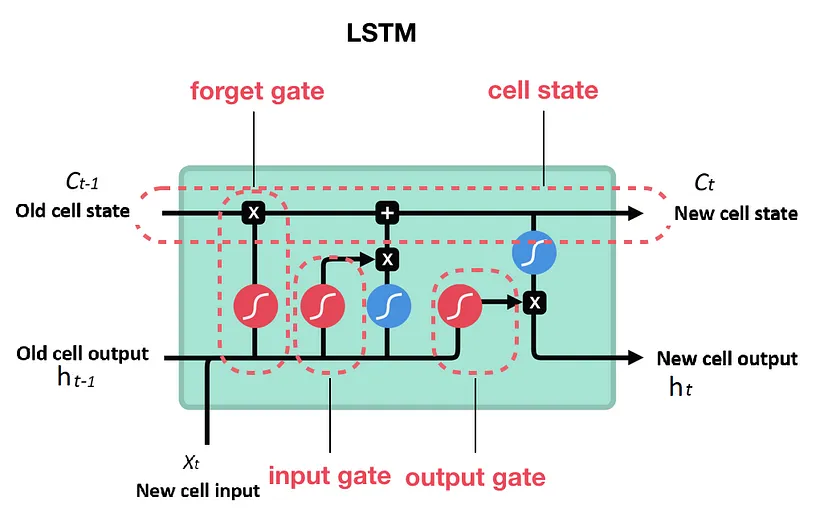

In [38]:
# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 20)            275460    
                                                                 
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 289,813
Trainable params: 289,813
Non-trainable params: 0
_________________________________________________________________


In [39]:
Y=to_categorical(df['Sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28386, 50) (28386, 3)
(5010, 50) (5010, 3)


In [40]:
history=model.fit(X_train, Y_train, epochs =50, batch_size=32, verbose = 2, validation_split=0.2)

Epoch 1/50
710/710 - 17s - loss: 0.7455 - accuracy: 0.6872 - val_loss: 0.6369 - val_accuracy: 0.7478 - 17s/epoch - 24ms/step
Epoch 2/50
710/710 - 14s - loss: 0.5817 - accuracy: 0.7745 - val_loss: 0.5710 - val_accuracy: 0.7767 - 14s/epoch - 20ms/step
Epoch 3/50
710/710 - 14s - loss: 0.5192 - accuracy: 0.7998 - val_loss: 0.5881 - val_accuracy: 0.7751 - 14s/epoch - 20ms/step
Epoch 4/50
710/710 - 14s - loss: 0.4795 - accuracy: 0.8127 - val_loss: 0.5313 - val_accuracy: 0.7895 - 14s/epoch - 20ms/step
Epoch 5/50
710/710 - 14s - loss: 0.4415 - accuracy: 0.8281 - val_loss: 0.5333 - val_accuracy: 0.7932 - 14s/epoch - 20ms/step
Epoch 6/50
710/710 - 14s - loss: 0.4048 - accuracy: 0.8438 - val_loss: 0.5247 - val_accuracy: 0.7948 - 14s/epoch - 20ms/step
Epoch 7/50
710/710 - 14s - loss: 0.3706 - accuracy: 0.8585 - val_loss: 0.5369 - val_accuracy: 0.7962 - 14s/epoch - 20ms/step
Epoch 8/50
710/710 - 14s - loss: 0.3382 - accuracy: 0.8728 - val_loss: 0.5389 - val_accuracy: 0.7996 - 14s/epoch - 20ms/step


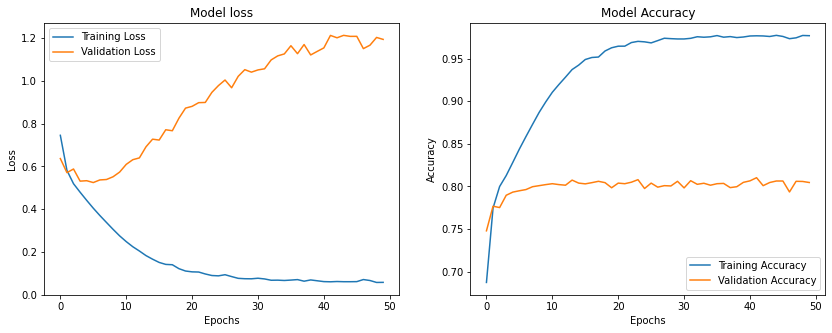

In [41]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs[0])

# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_classes)


[4.1278912e-05 7.9374969e-09 9.9995875e-01]
[2 1 0 ... 0 1 0]


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2394
           1       0.54      0.52      0.53       700
           2       0.83      0.84      0.84      1916

    accuracy                           0.80      5010
   macro avg       0.74      0.74      0.74      5010
weighted avg       0.80      0.80      0.80      5010

F1 Score:  0.8000292018675684


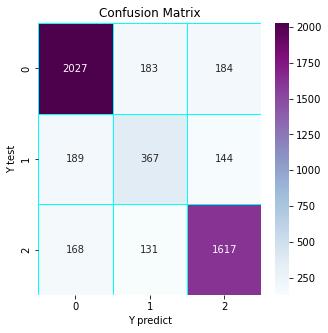

In [43]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels
evaluation_metrics(rounded_labels, yhat_classes)

In [44]:
message = ["The food at this restaurant was very bad"]
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 25ms/step
[[0.04496624 0.23586783 0.719166  ]] 2


**In above the cells, We use some basic techniques for sentiment analysis. Continuous of the code we change some parameters and advanced models. Then compare the result**

**In above the model, I guess overfitting is occurs**

# Part II

**Let's use advanced model.Other things are same word embedding type,size and etc.**

In [29]:
# Init layer
model = Sequential()

# Embed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index) + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# Batch Normalization
model.add(BatchNormalization())

# Bidirectional LSTM
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.5))  # Add dropout with 0.5 probability

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.5))  # Add dropout with 0.5 probability

# Dense layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))  # Add dropout with 0.5 probability
model.add(Dense(3, activation='softmax'))

# Output model skeleton
model.summary()

# Learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            275460    
                                                                 
 batch_normalization (BatchN  (None, 50, 20)           80        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 50, 50)            14200     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [30]:
Y=to_categorical(df['Sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26716, 50) (26716, 3)
(6680, 50) (6680, 3)


In [32]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
668/668 - 46s - loss: 0.7685 - accuracy: 0.6910 - val_loss: 0.6279 - val_accuracy: 0.7444 - lr: 0.0010 - 46s/epoch - 69ms/step
Epoch 2/50
668/668 - 42s - loss: 0.6235 - accuracy: 0.7632 - val_loss: 0.5669 - val_accuracy: 0.7708 - lr: 0.0010 - 42s/epoch - 64ms/step
Epoch 3/50
668/668 - 35s - loss: 0.5696 - accuracy: 0.7847 - val_loss: 0.5524 - val_accuracy: 0.7827 - lr: 0.0010 - 35s/epoch - 53ms/step
Epoch 4/50
668/668 - 28s - loss: 0.5444 - accuracy: 0.7972 - val_loss: 0.5458 - val_accuracy: 0.7842 - lr: 0.0010 - 28s/epoch - 42ms/step
Epoch 5/50
668/668 - 78s - loss: 0.5185 - accuracy: 0.8037 - val_loss: 0.5390 - val_accuracy: 0.7874 - lr: 0.0010 - 78s/epoch - 117ms/step
Epoch 6/50
668/668 - 30s - loss: 0.4938 - accuracy: 0.8124 - val_loss: 0.5188 - val_accuracy: 0.7985 - lr: 0.0010 - 30s/epoch - 45ms/step
Epoch 7/50
668/668 - 28s - loss: 0.4728 - accuracy: 0.8210 - val_loss: 0.5275 - val_accuracy: 0.7975 - lr: 0.0010 - 28s/epoch - 42ms/step
Epoch 8/50
668/668 - 29s - loss: 

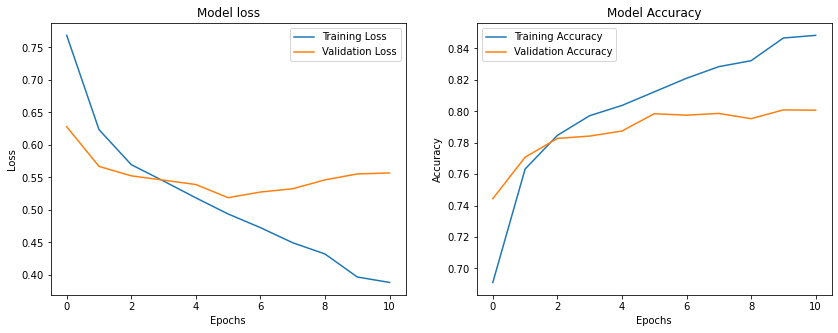

In [33]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs[0])

# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_classes)


[0.2817848  0.2654904  0.45272478]
[2 1 0 ... 2 0 0]


              precision    recall  f1-score   support

           0       0.80      0.90      0.85      3198
           1       0.78      0.25      0.37       939
           2       0.80      0.87      0.83      2543

    accuracy                           0.80      6680
   macro avg       0.79      0.67      0.69      6680
weighted avg       0.80      0.80      0.78      6680

F1 Score:  0.7762261628592751


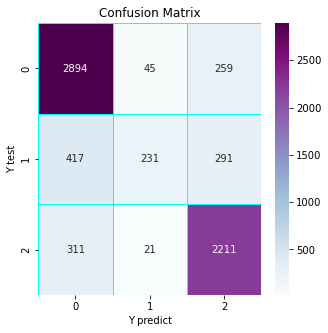

In [35]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels
evaluation_metrics(rounded_labels, yhat_classes)

**Advanced model result is worse than base result Because early stop call cancel the overfit and early epochs numbers**

#  Part III

**Double the MAX_SEQUENCE_LENGTH**

In [36]:
train_tagged = df.apply(
    lambda r: TaggedDocument(words=(r['review_token']), tags=[r.Sentiment]), axis=1)

In [37]:
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['review_token'].values)
X = tokenizer.texts_to_sequences(df['review_token'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
print('Found %s unique tokens.' % len(X))

Shape of data tensor: (33396, 100)
Found 33396 unique tokens.


In [38]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 33396/33396 [00:00<00:00, 2570382.17it/s]


In [39]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 33396/33396 [00:00<00:00, 3025987.82it/s]


Wall time: 49.8 s


In [40]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

for i, vec in enumerate(d2v_model.wv.vectors):
    embedding_matrix[i]=vec


In [41]:
# Init layer
model = Sequential()

# Embed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index) + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# Batch Normalization
model.add(BatchNormalization())

# Bidirectional LSTM
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.5))  # Add dropout with 0.5 probability

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.5))  # Add dropout with 0.5 probability

# Dense layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))  # Add dropout with 0.5 probability
model.add(Dense(3, activation='softmax'))

# Output model skeleton
model.summary()

# Learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 20)           275460    
                                                                 
 batch_normalization_1 (Batc  (None, 100, 20)          80        
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           14200     
                                                                 
 dropout_3 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                      

C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [42]:
Y=to_categorical(df['Sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26716, 100) (26716, 3)
(6680, 100) (6680, 3)


In [43]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
668/668 - 56s - loss: 0.8309 - accuracy: 0.6458 - val_loss: 0.6403 - val_accuracy: 0.7406 - lr: 0.0010 - 56s/epoch - 84ms/step
Epoch 2/50
668/668 - 52s - loss: 0.6416 - accuracy: 0.7580 - val_loss: 0.5700 - val_accuracy: 0.7769 - lr: 0.0010 - 52s/epoch - 78ms/step
Epoch 3/50
668/668 - 55s - loss: 0.5846 - accuracy: 0.7810 - val_loss: 0.5470 - val_accuracy: 0.7842 - lr: 0.0010 - 55s/epoch - 82ms/step
Epoch 4/50
668/668 - 52s - loss: 0.5440 - accuracy: 0.7958 - val_loss: 0.5347 - val_accuracy: 0.7910 - lr: 0.0010 - 52s/epoch - 79ms/step
Epoch 5/50
668/668 - 54s - loss: 0.5154 - accuracy: 0.8061 - val_loss: 0.5293 - val_accuracy: 0.7914 - lr: 0.0010 - 54s/epoch - 80ms/step
Epoch 6/50
668/668 - 54s - loss: 0.4896 - accuracy: 0.8146 - val_loss: 0.5222 - val_accuracy: 0.7973 - lr: 0.0010 - 54s/epoch - 81ms/step
Epoch 7/50
668/668 - 58s - loss: 0.4675 - accuracy: 0.8211 - val_loss: 0.5240 - val_accuracy: 0.7977 - lr: 0.0010 - 58s/epoch - 87ms/step
Epoch 8/50
668/668 - 57s - loss: 0

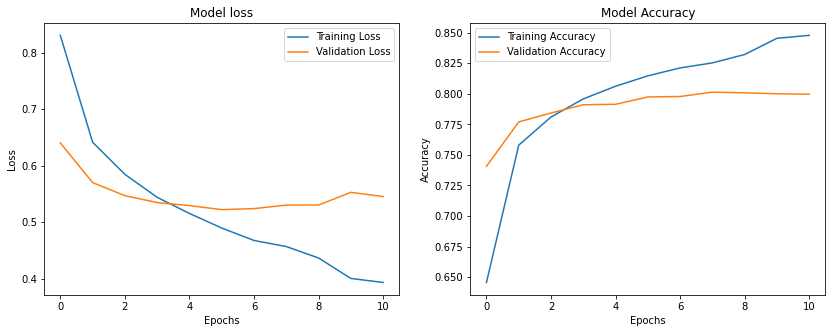

In [44]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [45]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs[0])

# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_classes)


[0.09960041 0.23743616 0.66296345]
[2 1 0 ... 2 2 0]


              precision    recall  f1-score   support

           0       0.80      0.92      0.85      3198
           1       0.84      0.22      0.35       939
           2       0.80      0.87      0.83      2543

    accuracy                           0.80      6680
   macro avg       0.81      0.67      0.68      6680
weighted avg       0.80      0.80      0.77      6680

F1 Score:  0.7734382706082207


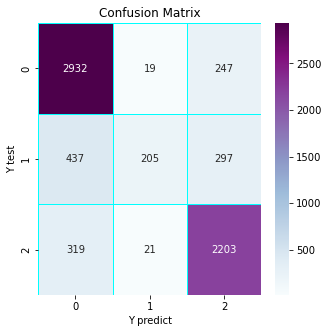

In [46]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels
evaluation_metrics(rounded_labels, yhat_classes)

**There has been no significant improvement or change**

#  Part IV

**Change the Layer type use Bidirectional Lstm and 1D convolutional layer**

In [47]:
train_tagged = df.apply(
    lambda r: TaggedDocument(words=(r['review_token']), tags=[r.Sentiment]), axis=1)

In [48]:
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['review_token'].values)
X = tokenizer.texts_to_sequences(df['review_token'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
print('Found %s unique tokens.' % len(X))

Shape of data tensor: (33396, 50)
Found 33396 unique tokens.


In [49]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 33396/33396 [00:00<00:00, 2455783.45it/s]


In [50]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 33396/33396 [00:00<00:00, 3328572.23it/s]


Wall time: 52.7 s


In [51]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

for i, vec in enumerate(d2v_model.wv.vectors):
    embedding_matrix[i]=vec


# Convolution layer

**What is Convolution layer ?**<br>
**-**  A convolutional layer is a primary component of Convolutional Neural Networks (CNNs), which are primarily used for processing structured grid data such as images.The key idea behind a convolutional layer is to use a mathematical operation called convolution to process the input data. In the context of a neural network, convolution is applying a set of filters to the input data to extract features or information from it.The filters are typically small matrices (kernels or weights) applied to the input data in a sliding window fashion. The filters are designed to detect specific patterns or features in the data, such as edges, shapes, or textures

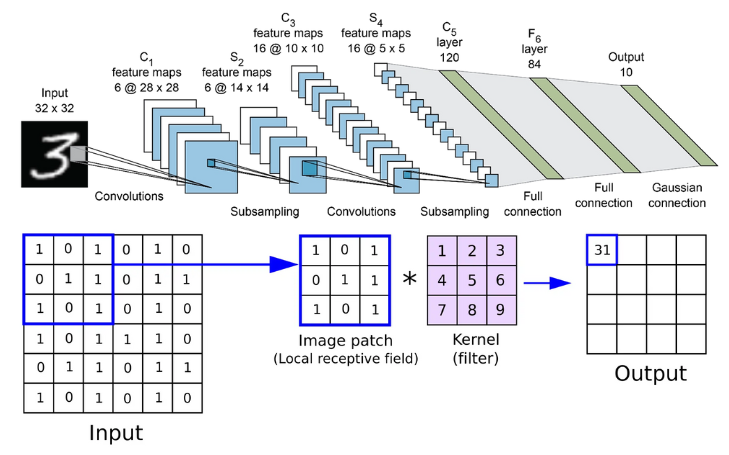

# Pooling layer

**What is Pooling layer ?**<br>
**-**  In neural networks, especially in Convolutional Neural Networks (CNNs), a pooling layer is often inserted between successive convolutional layers to reduce the spatial dimensions of the representation, thereby reducing the amount of parameters and computation in the network. Pooling layers work by downsampling the feature maps. But pooling is not just for reducing the dimension only, it also helps in extracting the dominant features like edges in the image.

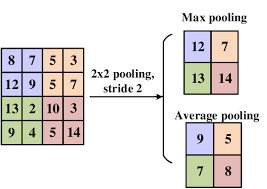

# Bidirectional LSTM

**What is Bidirectional LSTMs ?**<br>
**-**  Bidirectional LSTMs are a type of LSTM (Long Short Term Memory) network introduced to expand the capacity of classic LSTMs. The main idea behind them is to have two LSTMs for each time step of your data: one that processes the data from "past to future" (i.e., as it appears in the sequence) and another one that processes it from "future to past" (i.e., in reverse order).

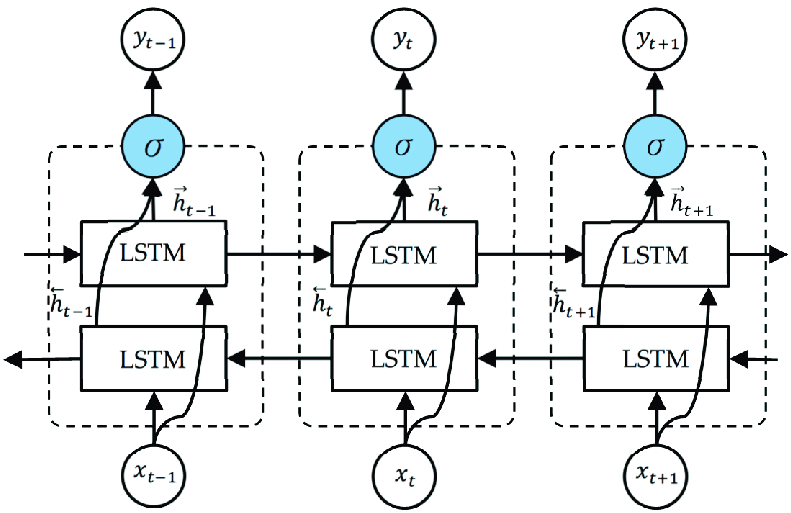

In [54]:
model = Sequential()

# Embedding layer
model.add(Embedding(len(d2v_model.wv.key_to_index) + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# 1D Convolutional layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))

# Bidirectional LSTM
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.5))


model.add(GlobalMaxPooling1D())

# Dense layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
# Model Summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 20)            275460    
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           12928     
                                                                 
 dropout_6 (Dropout)         (None, 46, 128)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 46, 100)          71600     
 l)                                                              
                                                                 
 dropout_7 (Dropout)         (None, 46, 100)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                       

C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [55]:
Y=to_categorical(df['Sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26716, 50) (26716, 3)
(6680, 50) (6680, 3)


In [56]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
668/668 - 28s - loss: 0.9264 - accuracy: 0.5932 - val_loss: 0.8634 - val_accuracy: 0.6634 - lr: 0.0010 - 28s/epoch - 42ms/step
Epoch 2/50
668/668 - 22s - loss: 0.7645 - accuracy: 0.6904 - val_loss: 0.6892 - val_accuracy: 0.7431 - lr: 0.0010 - 22s/epoch - 33ms/step
Epoch 3/50
668/668 - 22s - loss: 0.6509 - accuracy: 0.7517 - val_loss: 0.6303 - val_accuracy: 0.7569 - lr: 0.0010 - 22s/epoch - 32ms/step
Epoch 4/50
668/668 - 23s - loss: 0.5984 - accuracy: 0.7729 - val_loss: 0.6057 - val_accuracy: 0.7758 - lr: 0.0010 - 23s/epoch - 34ms/step
Epoch 5/50
668/668 - 22s - loss: 0.5604 - accuracy: 0.7874 - val_loss: 0.5801 - val_accuracy: 0.7794 - lr: 0.0010 - 22s/epoch - 33ms/step
Epoch 6/50
668/668 - 21s - loss: 0.5378 - accuracy: 0.7945 - val_loss: 0.5843 - val_accuracy: 0.7829 - lr: 0.0010 - 21s/epoch - 31ms/step
Epoch 7/50
668/668 - 21s - loss: 0.5220 - accuracy: 0.8042 - val_loss: 0.5684 - val_accuracy: 0.7925 - lr: 0.0010 - 21s/epoch - 31ms/step
Epoch 8/50
668/668 - 21s - loss: 0

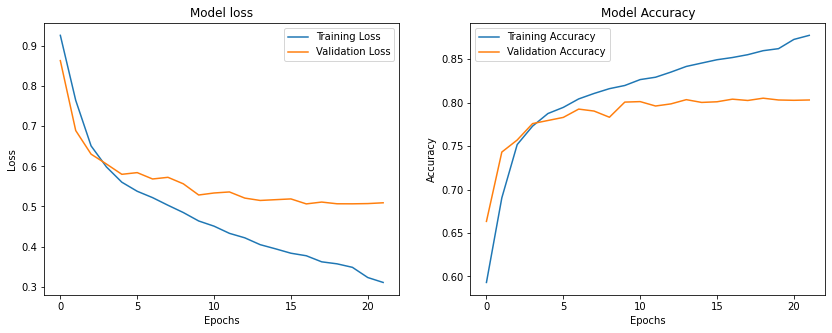

In [57]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs[0])

# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_classes)


[0.45102963 0.29259807 0.25637233]
[0 1 0 ... 2 2 0]


              precision    recall  f1-score   support

           0       0.77      0.94      0.85      3198
           1       0.92      0.21      0.34       939
           2       0.84      0.84      0.84      2543

    accuracy                           0.80      6680
   macro avg       0.84      0.66      0.68      6680
weighted avg       0.82      0.80      0.77      6680

F1 Score:  0.7729064864303911


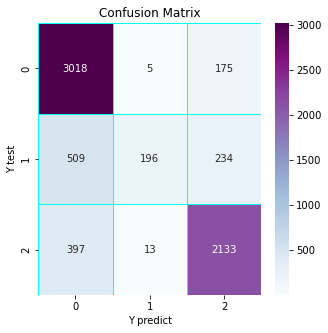

In [59]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels
evaluation_metrics(rounded_labels, yhat_classes)

**There has been no significant improvement or change.Maybe we can try to optimize DOC2VEC model because changing model Did not improve the result**

# PART V

**Let's optimize the DOC2VEC model**

In [19]:
train_tagged = df.apply(
    lambda r: TaggedDocument(words=(r['review_token']), tags=[r.Sentiment]), axis=1)

param_grid = {
    'dm': [0, 1],  # 0 = DBOW; 1 = DM
    'vector_size': [10, 20, 30, 50],  # Just two options instead of three
    'window': [5, 8, 10],  # Reduced to two common window sizes
    'min_count': [1],  # Most common minimum counts
    'alpha': [0.065],  # More common learning rates
    'min_alpha': [0.065],
}
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['review_token'].values)
X = tokenizer.texts_to_sequences(df['review_token'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
print('Found %s unique tokens.' % len(X))
best_model = None
best_score = float('-inf')  # Assuming you want to maximize some score. If minimizing (e.g., loss), use float('inf')

for params in tqdm(list(ParameterGrid(param_grid))):
    d2v_model = Doc2Vec(
        dm=params['dm'],
        vector_size=params['vector_size'],
        window=params['window'],
        min_count=params['min_count'],
        alpha=params['alpha'],
        min_alpha=params['min_alpha'],
        workers=4
    )
    print(f"Training with parameters: {params}")
    d2v_model.build_vocab([x for x in train_tagged.values])
    
    # You can adjust this training loop based on your params if needed
    for epoch in range(30):
        d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        d2v_model.alpha -= 0.002
        d2v_model.min_alpha = d2v_model.alpha
    # save the vectors in a new matrix
    embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, params['vector_size']))

    for i, vec in enumerate(d2v_model.wv.vectors):
        embedding_matrix[i]=vec
    
    model = Sequential()

    # Embedding layer
    model.add(Embedding(len(d2v_model.wv.key_to_index) + 1, params['vector_size'], input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

    # 1D Convolutional layer
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(Dropout(0.5))

    # Bidirectional LSTM
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Dropout(0.5))


    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))

    # Compile the model
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # Learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
    
    Y=to_categorical(df['Sentiment'])
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

    
    # Train the model
    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
    # predict probabilities for test set
    yhat_probs = model.predict(X_test, verbose=0)
    print(yhat_probs[0])

    # predict crisp classes for test set
    yhat_classes = np.argmax(yhat_probs, axis=1)
    print(yhat_classes)
    rounded_labels=np.argmax(Y_test, axis=1)
    score = f1_score(rounded_labels, yhat_classes, average='weighted')
    print(score)
    if score > best_score:
        best_score = score
        best_model = d2v_model

print(f"Best Score: {best_score}")
print(f"Best Model Parameters: {best_model}")

Shape of data tensor: (33396, 50)
Found 33396 unique tokens.


  0%|          | 0/24 [00:00<?, ?it/s]

Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 10, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 2223733.55it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227234.05it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2087307.98it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1964337.47it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1517205.64it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1964668.09it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1335809.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385764.01it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562060.59it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2789964.87it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227269.46it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1669980.76it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036483.34it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3328097.71it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2777627.48it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775921.05it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50
668/668 - 55s - loss: 0.7201 - accuracy: 0.7114 - val_loss: 0.5989 - val_accuracy: 0.7740 - lr: 0.0010 - 55s/epoch - 83ms/step
Epoch 2/50
668/668 - 50s - loss: 0.5284 - accuracy: 0.8013 - val_loss: 0.5521 - val_accuracy: 0.8084 - lr: 0.0010 - 50s/epoch - 75ms/step
Epoch 3/50
668/668 - 50s - loss: 0.4718 - accuracy: 0.8259 - val_loss: 0.5349 - val_accuracy: 0.8101 - lr: 0.0010 - 50s/epoch - 75ms/step
Epoch 4/50
668/668 - 50s - loss: 0.4277 - accuracy: 0.8420 - val_loss: 0.5307 - val_accuracy: 0.8048 - lr: 0.0010 - 50s/epoch - 75ms/step
Epoch 5/50
668/668 - 49s - loss: 0.3786 - accuracy: 0.8607 - val_loss: 0.5137 - val_accuracy: 0.7975 - lr: 0.0010 - 49s/epoch - 73ms/step
Epoch 6/50
668/668 - 58s - loss: 0.3470 - accuracy: 0.8716 - val_loss: 0.5226 - val_accuracy: 0.7917 - lr: 0.0010 - 58s/epoch - 87ms/step
Epoch 7/50
668/668 - 51s - loss: 0.3180 - accuracy: 0.8817 - val_loss: 0.5228 - val_accuracy: 0.7936 - lr: 0.0010 - 51s/epoch - 76ms/step
Epoch 8/50

Epoch 8: ReduceLROnPla

  4%|▍         | 1/24 [09:31<3:38:54, 571.09s/it]

[0.06180273 0.1722431  0.76595414]
[2 1 0 ... 2 1 0]
0.7946020394649069
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 10, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 1237120.57it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2228296.98it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2788631.82it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1758098.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2428997.11it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1627525.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2127281.48it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569297.78it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569250.65it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2778950.03it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2516944.16it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2221088.98it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569344.91it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1391573.21it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2566097.10it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2087339.08it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 42s - loss: 0.7166 - accuracy: 0.7148 - val_loss: 0.6164 - val_accuracy: 0.7717 - lr: 0.0010 - 42s/epoch - 63ms/step
Epoch 2/50
668/668 - 39s - loss: 0.5271 - accuracy: 0.8034 - val_loss: 0.5920 - val_accuracy: 0.7968 - lr: 0.0010 - 39s/epoch - 58ms/step
Epoch 3/50
668/668 - 38s - loss: 0.4680 - accuracy: 0.8250 - val_loss: 0.5541 - val_accuracy: 0.8005 - lr: 0.0010 - 38s/epoch - 57ms/step
Epoch 4/50
668/668 - 38s - loss: 0.4272 - accuracy: 0.8438 - val_loss: 0.5299 - val_accuracy: 0.8039 - lr: 0.0010 - 38s/epoch - 56ms/step
Epoch 5/50
668/668 - 37s - loss: 0.3804 - accuracy: 0.8577 - val_loss: 0.5159 - val_accuracy: 0.8009 - lr: 0.0010 - 37s/epoch - 56ms/step
Epoch 6/50
668/668 - 38s - loss: 0.3397 - accuracy: 0.8739 - val_loss: 0.5126 - val_accuracy: 0.7975 - lr: 0.0010 - 38s/epoch - 56ms/step
Epoch 7/50
668/668 - 38s - loss: 0.3118 - accuracy: 0.8833 - val_loss: 0.5229 - val_accuracy: 0.8056 - lr: 0.0010 - 38s/epoch - 57ms/step
Epoch 8/50
668/668 - 38s - loss: 0.2881 - acc

  8%|▊         | 2/24 [17:27<3:08:55, 515.25s/it]

[0.22494015 0.461136   0.31392384]
[1 1 0 ... 2 2 0]
0.7895919492240769
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 10, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 2457506.87it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3025334.26it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1698163.02it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2779115.44it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1960817.74it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2786856.40it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2771691.56it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226278.27it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783533.57it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3010703.42it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2788409.77it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2570712.38it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1452978.88it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2773392.79it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2384586.17it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3040305.96it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 42s - loss: 0.7167 - accuracy: 0.7124 - val_loss: 0.6133 - val_accuracy: 0.7700 - lr: 0.0010 - 42s/epoch - 62ms/step
Epoch 2/50
668/668 - 42s - loss: 0.5266 - accuracy: 0.8010 - val_loss: 0.5594 - val_accuracy: 0.7977 - lr: 0.0010 - 42s/epoch - 62ms/step
Epoch 3/50
668/668 - 42s - loss: 0.4653 - accuracy: 0.8301 - val_loss: 0.5413 - val_accuracy: 0.8020 - lr: 0.0010 - 42s/epoch - 63ms/step
Epoch 4/50
668/668 - 42s - loss: 0.4183 - accuracy: 0.8449 - val_loss: 0.5200 - val_accuracy: 0.8003 - lr: 0.0010 - 42s/epoch - 64ms/step
Epoch 5/50
668/668 - 42s - loss: 0.3691 - accuracy: 0.8646 - val_loss: 0.5205 - val_accuracy: 0.7938 - lr: 0.0010 - 42s/epoch - 63ms/step
Epoch 6/50
668/668 - 42s - loss: 0.3361 - accuracy: 0.8754 - val_loss: 0.5235 - val_accuracy: 0.7936 - lr: 0.0010 - 42s/epoch - 63ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
668/668 - 43s - loss: 0.3077 - accuracy: 0.8866 - val_loss: 0.5293 - val_accuracy: 0.7929 - lr

 12%|█▎        | 3/24 [24:41<2:47:26, 478.41s/it]

[0.06294996 0.19033304 0.746717  ]
[2 1 0 ... 2 1 0]
0.789218762361647
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 20, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 1962191.14it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2560655.49it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2220596.02it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562529.30it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2582371.16it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562294.92it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2380857.28it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2645381.99it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3035759.44it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1517781.04it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562810.60it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1960845.19it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2572317.49it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2381059.64it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569297.78it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2567978.89it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 42s - loss: 0.6795 - accuracy: 0.7332 - val_loss: 0.5725 - val_accuracy: 0.7760 - lr: 0.0010 - 42s/epoch - 62ms/step
Epoch 2/50
668/668 - 37s - loss: 0.5109 - accuracy: 0.8047 - val_loss: 0.5658 - val_accuracy: 0.8088 - lr: 0.0010 - 37s/epoch - 56ms/step
Epoch 3/50
668/668 - 37s - loss: 0.4473 - accuracy: 0.8330 - val_loss: 0.5282 - val_accuracy: 0.7970 - lr: 0.0010 - 37s/epoch - 56ms/step
Epoch 4/50
668/668 - 37s - loss: 0.3926 - accuracy: 0.8571 - val_loss: 0.5372 - val_accuracy: 0.7934 - lr: 0.0010 - 37s/epoch - 56ms/step
Epoch 5/50
668/668 - 38s - loss: 0.3391 - accuracy: 0.8740 - val_loss: 0.5197 - val_accuracy: 0.7930 - lr: 0.0010 - 38s/epoch - 56ms/step
Epoch 6/50
668/668 - 37s - loss: 0.3038 - accuracy: 0.8896 - val_loss: 0.5268 - val_accuracy: 0.7908 - lr: 0.0010 - 37s/epoch - 56ms/step
Epoch 7/50
668/668 - 37s - loss: 0.2728 - accuracy: 0.8980 - val_loss: 0.5634 - val_accuracy: 0.7891 - lr: 0.0010 - 37s/epoch - 56ms/step
Epoch 8/50

Epoch 8: ReduceLROnPlateau reduci

 17%|█▋        | 4/24 [31:51<2:33:01, 459.10s/it]

[0.12221929 0.37793982 0.49984092]
[2 1 1 ... 2 1 0]
0.7905395207259487
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 20, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 2223627.65it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2376535.06it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2086592.83it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2785193.99it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379684.29it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775646.02it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2566050.09it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2236158.63it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2786856.40it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3021418.82it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2563045.07it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776416.25it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2647031.70it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2384139.71it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2381181.07it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2382031.43it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 41s - loss: 0.6841 - accuracy: 0.7317 - val_loss: 0.5872 - val_accuracy: 0.7730 - lr: 0.0010 - 41s/epoch - 62ms/step
Epoch 2/50
668/668 - 34s - loss: 0.5130 - accuracy: 0.8103 - val_loss: 0.5546 - val_accuracy: 0.7754 - lr: 0.0010 - 34s/epoch - 51ms/step
Epoch 3/50
668/668 - 34s - loss: 0.4461 - accuracy: 0.8356 - val_loss: 0.5658 - val_accuracy: 0.7955 - lr: 0.0010 - 34s/epoch - 51ms/step
Epoch 4/50
668/668 - 34s - loss: 0.3958 - accuracy: 0.8570 - val_loss: 0.5367 - val_accuracy: 0.7958 - lr: 0.0010 - 34s/epoch - 51ms/step
Epoch 5/50
668/668 - 34s - loss: 0.3528 - accuracy: 0.8729 - val_loss: 0.5418 - val_accuracy: 0.7871 - lr: 0.0010 - 34s/epoch - 51ms/step
Epoch 6/50
668/668 - 34s - loss: 0.3042 - accuracy: 0.8900 - val_loss: 0.5530 - val_accuracy: 0.7914 - lr: 0.0010 - 34s/epoch - 51ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
668/668 - 34s - loss: 0.2769 - accuracy: 0.8980 - val_loss: 0.5975 - val_accuracy: 0.7837 - lr

 21%|██        | 5/24 [37:55<2:14:35, 425.03s/it]

[0.05840379 0.22011681 0.7214794 ]
[2 1 0 ... 2 1 0]
0.792449629819878
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 20, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 1757921.92it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776636.40it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1963759.15it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2380695.42it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227021.58it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2225853.75it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562388.67it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2198119.65it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3046322.97it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1519262.63it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2388326.76it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379846.01it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562435.54it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2083055.39it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2380331.31it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2564077.26it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 36s - loss: 0.6899 - accuracy: 0.7294 - val_loss: 0.5882 - val_accuracy: 0.7730 - lr: 0.0010 - 36s/epoch - 53ms/step
Epoch 2/50
668/668 - 32s - loss: 0.5144 - accuracy: 0.8059 - val_loss: 0.5761 - val_accuracy: 0.7994 - lr: 0.0010 - 32s/epoch - 48ms/step
Epoch 3/50
668/668 - 32s - loss: 0.4458 - accuracy: 0.8350 - val_loss: 0.5287 - val_accuracy: 0.8007 - lr: 0.0010 - 32s/epoch - 47ms/step
Epoch 4/50
668/668 - 31s - loss: 0.3953 - accuracy: 0.8550 - val_loss: 0.5363 - val_accuracy: 0.7943 - lr: 0.0010 - 31s/epoch - 47ms/step
Epoch 5/50
668/668 - 32s - loss: 0.3548 - accuracy: 0.8719 - val_loss: 0.5554 - val_accuracy: 0.7762 - lr: 0.0010 - 32s/epoch - 47ms/step
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
668/668 - 31s - loss: 0.3271 - accuracy: 0.8835 - val_loss: 0.5521 - val_accuracy: 0.7885 - lr: 0.0010 - 31s/epoch - 47ms/step
Epoch 7/50
668/668 - 31s - loss: 0.2646 - accuracy: 0.9091 - val_loss: 0.5648 - val_accuracy: 0.7807 - lr

 25%|██▌       | 6/24 [43:04<1:55:39, 385.54s/it]

[0.04984711 0.15941025 0.7907427 ]
[2 1 0 ... 2 1 0]
0.7866269791562424
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 30, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 3037536.90it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2224051.32it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385438.97it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2563936.45it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783533.57it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775976.07it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562482.42it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2556869.40it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562951.28it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2777076.79it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562951.28it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379280.07it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1518110.03it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379037.61it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1858249.33it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2672026.56it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 58s - loss: 0.6756 - accuracy: 0.7354 - val_loss: 0.5784 - val_accuracy: 0.8007 - lr: 0.0010 - 58s/epoch - 86ms/step
Epoch 2/50
668/668 - 52s - loss: 0.5099 - accuracy: 0.8095 - val_loss: 0.5528 - val_accuracy: 0.8045 - lr: 0.0010 - 52s/epoch - 79ms/step
Epoch 3/50
668/668 - 51s - loss: 0.4340 - accuracy: 0.8401 - val_loss: 0.5290 - val_accuracy: 0.8031 - lr: 0.0010 - 51s/epoch - 76ms/step
Epoch 4/50
668/668 - 52s - loss: 0.3774 - accuracy: 0.8629 - val_loss: 0.5207 - val_accuracy: 0.7955 - lr: 0.0010 - 52s/epoch - 77ms/step
Epoch 5/50
668/668 - 51s - loss: 0.3297 - accuracy: 0.8808 - val_loss: 0.5105 - val_accuracy: 0.7968 - lr: 0.0010 - 51s/epoch - 76ms/step
Epoch 6/50
668/668 - 51s - loss: 0.2817 - accuracy: 0.8986 - val_loss: 0.5285 - val_accuracy: 0.7932 - lr: 0.0010 - 51s/epoch - 76ms/step
Epoch 7/50
668/668 - 51s - loss: 0.2555 - accuracy: 0.9085 - val_loss: 0.5465 - val_accuracy: 0.7929 - lr: 0.0010 - 51s/epoch - 76ms/step
Epoch 8/50

Epoch 8: ReduceLROnPlateau reduci

 29%|██▉       | 7/24 [52:36<2:06:30, 446.48s/it]

[0.238287   0.40448555 0.35722747]
[1 1 0 ... 2 2 0]
0.7957075660647462
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 30, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 2780936.22it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2564311.96it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3033524.12it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569627.72it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775096.11it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1960735.40it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1464907.36it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2786690.07it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2564875.42it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1964640.54it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1546486.08it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3014331.63it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3014526.24it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2670447.38it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569250.65it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2519479.39it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 54s - loss: 0.6830 - accuracy: 0.7296 - val_loss: 0.5725 - val_accuracy: 0.7771 - lr: 0.0010 - 54s/epoch - 80ms/step
Epoch 2/50
668/668 - 49s - loss: 0.5041 - accuracy: 0.8088 - val_loss: 0.5454 - val_accuracy: 0.8104 - lr: 0.0010 - 49s/epoch - 73ms/step
Epoch 3/50
668/668 - 51s - loss: 0.4397 - accuracy: 0.8367 - val_loss: 0.5282 - val_accuracy: 0.7957 - lr: 0.0010 - 51s/epoch - 76ms/step
Epoch 4/50
668/668 - 50s - loss: 0.3889 - accuracy: 0.8585 - val_loss: 0.5412 - val_accuracy: 0.7936 - lr: 0.0010 - 50s/epoch - 74ms/step
Epoch 5/50
668/668 - 48s - loss: 0.3355 - accuracy: 0.8778 - val_loss: 0.5119 - val_accuracy: 0.7992 - lr: 0.0010 - 48s/epoch - 72ms/step
Epoch 6/50
668/668 - 48s - loss: 0.2958 - accuracy: 0.8900 - val_loss: 0.5352 - val_accuracy: 0.7943 - lr: 0.0010 - 48s/epoch - 72ms/step
Epoch 7/50
668/668 - 48s - loss: 0.2714 - accuracy: 0.9007 - val_loss: 0.5589 - val_accuracy: 0.7863 - lr: 0.0010 - 48s/epoch - 72ms/step
Epoch 8/50

Epoch 8: ReduceLROnPlateau reduci

 33%|███▎      | 8/24 [1:01:46<2:07:50, 479.39s/it]

[0.09039531 0.27749056 0.6321142 ]
[2 1 0 ... 2 1 0]
0.7926925515435693
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 30, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 2881507.81it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783201.72it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036417.51it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3345825.30it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3030570.67it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2731265.99it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562810.60it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775701.02it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569015.05it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2782925.25it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2982560.61it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2386089.13it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569109.28it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783478.26it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3038657.10it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3034115.50it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 42s - loss: 0.6737 - accuracy: 0.7358 - val_loss: 0.5688 - val_accuracy: 0.7766 - lr: 0.0010 - 42s/epoch - 62ms/step
Epoch 2/50
668/668 - 37s - loss: 0.5009 - accuracy: 0.8124 - val_loss: 0.5408 - val_accuracy: 0.8065 - lr: 0.0010 - 37s/epoch - 55ms/step
Epoch 3/50
668/668 - 39s - loss: 0.4322 - accuracy: 0.8404 - val_loss: 0.5289 - val_accuracy: 0.8031 - lr: 0.0010 - 39s/epoch - 58ms/step
Epoch 4/50
668/668 - 38s - loss: 0.3790 - accuracy: 0.8634 - val_loss: 0.5175 - val_accuracy: 0.7945 - lr: 0.0010 - 38s/epoch - 57ms/step
Epoch 5/50
668/668 - 36s - loss: 0.3260 - accuracy: 0.8820 - val_loss: 0.5107 - val_accuracy: 0.8020 - lr: 0.0010 - 36s/epoch - 54ms/step
Epoch 6/50
668/668 - 36s - loss: 0.2855 - accuracy: 0.8968 - val_loss: 0.5270 - val_accuracy: 0.7938 - lr: 0.0010 - 36s/epoch - 54ms/step
Epoch 7/50
668/668 - 36s - loss: 0.2508 - accuracy: 0.9113 - val_loss: 0.5416 - val_accuracy: 0.7945 - lr: 0.0010 - 36s/epoch - 54ms/step
Epoch 8/50

Epoch 8: ReduceLROnPlateau reduci

 38%|███▊      | 9/24 [1:08:57<1:56:04, 464.32s/it]

[0.10332686 0.30529886 0.59137434]
[2 1 0 ... 2 1 0]
0.7936794338542693
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 50, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 2570429.34it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2571609.11it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2076416.44it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562576.18it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2094110.79it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226632.17it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226667.56it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1758628.19it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2757559.19it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2079128.65it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569910.58it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2148885.87it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379603.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2388367.49it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2575344.30it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2412098.58it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 64s - loss: 0.6630 - accuracy: 0.7356 - val_loss: 0.5833 - val_accuracy: 0.7762 - lr: 0.0010 - 64s/epoch - 96ms/step
Epoch 2/50
668/668 - 62s - loss: 0.4994 - accuracy: 0.8111 - val_loss: 0.5381 - val_accuracy: 0.8071 - lr: 0.0010 - 62s/epoch - 93ms/step
Epoch 3/50
668/668 - 50s - loss: 0.4309 - accuracy: 0.8419 - val_loss: 0.5290 - val_accuracy: 0.7988 - lr: 0.0010 - 50s/epoch - 75ms/step
Epoch 4/50
668/668 - 49s - loss: 0.3718 - accuracy: 0.8662 - val_loss: 0.5243 - val_accuracy: 0.7981 - lr: 0.0010 - 49s/epoch - 73ms/step
Epoch 5/50
668/668 - 48s - loss: 0.3125 - accuracy: 0.8858 - val_loss: 0.5315 - val_accuracy: 0.7938 - lr: 0.0010 - 48s/epoch - 72ms/step
Epoch 6/50
668/668 - 50s - loss: 0.2759 - accuracy: 0.8985 - val_loss: 0.5556 - val_accuracy: 0.7833 - lr: 0.0010 - 50s/epoch - 75ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
668/668 - 48s - loss: 0.2505 - accuracy: 0.9120 - val_loss: 0.5607 - val_accuracy: 0.8046 - lr

 42%|████▏     | 10/24 [1:17:43<1:52:43, 483.12s/it]

[0.2011578 0.4507592 0.348083 ]
[1 1 0 ... 2 1 0]
0.7848195975918498
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 50, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 2229893.28it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1589859.44it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562060.59it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385154.64it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1518044.22it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783976.16it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3039580.24it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1669721.97it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2790020.44it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1964668.09it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569203.53it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2572034.09it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2570523.68it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2076631.92it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3026576.27it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036746.66it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 53s - loss: 0.6723 - accuracy: 0.7359 - val_loss: 0.5889 - val_accuracy: 0.7764 - lr: 0.0010 - 53s/epoch - 79ms/step
Epoch 2/50
668/668 - 46s - loss: 0.5023 - accuracy: 0.8121 - val_loss: 0.5448 - val_accuracy: 0.8035 - lr: 0.0010 - 46s/epoch - 68ms/step
Epoch 3/50
668/668 - 45s - loss: 0.4245 - accuracy: 0.8382 - val_loss: 0.5142 - val_accuracy: 0.8076 - lr: 0.0010 - 45s/epoch - 68ms/step
Epoch 4/50
668/668 - 45s - loss: 0.3573 - accuracy: 0.8628 - val_loss: 0.5067 - val_accuracy: 0.8058 - lr: 0.0010 - 45s/epoch - 67ms/step
Epoch 5/50
668/668 - 45s - loss: 0.3135 - accuracy: 0.8833 - val_loss: 0.5140 - val_accuracy: 0.8048 - lr: 0.0010 - 45s/epoch - 67ms/step
Epoch 6/50
668/668 - 45s - loss: 0.2757 - accuracy: 0.9001 - val_loss: 0.5350 - val_accuracy: 0.8026 - lr: 0.0010 - 45s/epoch - 68ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
668/668 - 45s - loss: 0.2448 - accuracy: 0.9137 - val_loss: 0.5469 - val_accuracy: 0.8080 - lr

 46%|████▌     | 11/24 [1:25:36<1:44:00, 480.06s/it]

[0.16582169 0.34969524 0.48448306]
[2 1 0 ... 2 2 0]
0.7908235612109115
Training with parameters: {'alpha': 0.065, 'dm': 0, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 50, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 2564593.66it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783312.33it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2386007.84it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2575202.26it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3029194.36it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3026183.95it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2383166.20it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2773832.16it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3027426.65it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776306.19it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2788576.31it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036285.88it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3026249.33it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385479.60it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776196.14it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562388.67it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 46s - loss: 0.6601 - accuracy: 0.7359 - val_loss: 0.5882 - val_accuracy: 0.7670 - lr: 0.0010 - 46s/epoch - 68ms/step
Epoch 2/50
668/668 - 41s - loss: 0.4983 - accuracy: 0.8131 - val_loss: 0.5549 - val_accuracy: 0.8097 - lr: 0.0010 - 41s/epoch - 61ms/step
Epoch 3/50
668/668 - 40s - loss: 0.4184 - accuracy: 0.8445 - val_loss: 0.5389 - val_accuracy: 0.7977 - lr: 0.0010 - 40s/epoch - 60ms/step
Epoch 4/50
668/668 - 40s - loss: 0.3518 - accuracy: 0.8711 - val_loss: 0.5306 - val_accuracy: 0.7919 - lr: 0.0010 - 40s/epoch - 60ms/step
Epoch 5/50
668/668 - 40s - loss: 0.2995 - accuracy: 0.8886 - val_loss: 0.5230 - val_accuracy: 0.7996 - lr: 0.0010 - 40s/epoch - 60ms/step
Epoch 6/50
668/668 - 40s - loss: 0.2595 - accuracy: 0.9070 - val_loss: 0.5454 - val_accuracy: 0.7902 - lr: 0.0010 - 40s/epoch - 60ms/step
Epoch 7/50
668/668 - 40s - loss: 0.2314 - accuracy: 0.9155 - val_loss: 0.5690 - val_accuracy: 0.7874 - lr: 0.0010 - 40s/epoch - 60ms/step
Epoch 8/50

Epoch 8: ReduceLROnPlateau reduci

 50%|█████     | 12/24 [1:33:17<1:34:52, 474.36s/it]

[0.22749966 0.46030453 0.31219578]
[1 1 1 ... 2 2 0]
0.7956873830152303
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 10, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 2571514.68it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783201.72it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3041824.50it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3342392.30it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775811.03it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3038591.18it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2564969.35it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036285.88it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2309377.39it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2572317.49it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569250.65it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3329284.25it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3027492.09it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2777902.91it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2770869.13it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2386089.13it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 53s - loss: 0.8933 - accuracy: 0.5996 - val_loss: 0.8342 - val_accuracy: 0.6645 - lr: 0.0010 - 53s/epoch - 80ms/step
Epoch 2/50
668/668 - 77s - loss: 0.7574 - accuracy: 0.6856 - val_loss: 0.7611 - val_accuracy: 0.7178 - lr: 0.0010 - 77s/epoch - 115ms/step
Epoch 3/50
668/668 - 71s - loss: 0.6567 - accuracy: 0.7423 - val_loss: 0.6499 - val_accuracy: 0.7633 - lr: 0.0010 - 71s/epoch - 107ms/step
Epoch 4/50
668/668 - 70s - loss: 0.6000 - accuracy: 0.7683 - val_loss: 0.6349 - val_accuracy: 0.7751 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 5/50
668/668 - 70s - loss: 0.5686 - accuracy: 0.7828 - val_loss: 0.6095 - val_accuracy: 0.7854 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 6/50
668/668 - 70s - loss: 0.5489 - accuracy: 0.7924 - val_loss: 0.5907 - val_accuracy: 0.7865 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 7/50
668/668 - 70s - loss: 0.5252 - accuracy: 0.8018 - val_loss: 0.5896 - val_accuracy: 0.7893 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 8/50
668/668 - 71s - loss: 0.5106

 54%|█████▍    | 13/24 [2:04:36<2:44:57, 899.75s/it]

[0.01813481 0.15430926 0.82755595]
[2 1 0 ... 2 2 0]
0.77994021773686
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 10, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 2230710.05it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3040239.98it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226773.76it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2572506.45it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1151499.26it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226278.27it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227127.81it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3027099.53it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562060.59it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2774876.21it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3029390.90it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569297.78it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1284248.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569062.16it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1964585.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2778894.90it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 75s - loss: 0.9162 - accuracy: 0.5938 - val_loss: 0.8629 - val_accuracy: 0.6357 - lr: 0.0010 - 75s/epoch - 112ms/step
Epoch 2/50
668/668 - 70s - loss: 0.7976 - accuracy: 0.6594 - val_loss: 0.7784 - val_accuracy: 0.6866 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 3/50
668/668 - 72s - loss: 0.7057 - accuracy: 0.7161 - val_loss: 0.7295 - val_accuracy: 0.7455 - lr: 0.0010 - 72s/epoch - 108ms/step
Epoch 4/50
668/668 - 69s - loss: 0.6501 - accuracy: 0.7416 - val_loss: 0.6615 - val_accuracy: 0.7562 - lr: 0.0010 - 69s/epoch - 104ms/step
Epoch 5/50
668/668 - 70s - loss: 0.6111 - accuracy: 0.7660 - val_loss: 0.6583 - val_accuracy: 0.7687 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 6/50
668/668 - 70s - loss: 0.5795 - accuracy: 0.7769 - val_loss: 0.6485 - val_accuracy: 0.7711 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 7/50
668/668 - 71s - loss: 0.5488 - accuracy: 0.7926 - val_loss: 0.6305 - val_accuracy: 0.7818 - lr: 0.0010 - 71s/epoch - 106ms/step
Epoch 8/50
668/668 - 70s - loss: 0.530

 58%|█████▊    | 14/24 [2:35:22<3:17:37, 1185.79s/it]

[0.20336354 0.29173216 0.5049043 ]
[2 1 0 ... 2 0 0]
0.7745438032580051
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 10, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 2088521.74it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1361544.51it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1906792.49it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783367.64it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2778453.93it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569863.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2089518.71it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1284377.96it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783588.89it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2085257.12it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226349.04it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2779832.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776526.32it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2225075.87it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036944.18it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226950.77it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 72s - loss: 0.9128 - accuracy: 0.5960 - val_loss: 0.8568 - val_accuracy: 0.6488 - lr: 0.0010 - 72s/epoch - 108ms/step
Epoch 2/50
668/668 - 68s - loss: 0.7721 - accuracy: 0.6846 - val_loss: 0.7242 - val_accuracy: 0.7277 - lr: 0.0010 - 68s/epoch - 102ms/step
Epoch 3/50
668/668 - 68s - loss: 0.6809 - accuracy: 0.7352 - val_loss: 0.6427 - val_accuracy: 0.7528 - lr: 0.0010 - 68s/epoch - 102ms/step
Epoch 4/50
668/668 - 68s - loss: 0.6245 - accuracy: 0.7582 - val_loss: 0.6263 - val_accuracy: 0.7646 - lr: 0.0010 - 68s/epoch - 102ms/step
Epoch 5/50
668/668 - 66s - loss: 0.5931 - accuracy: 0.7738 - val_loss: 0.5992 - val_accuracy: 0.7734 - lr: 0.0010 - 66s/epoch - 98ms/step
Epoch 6/50
668/668 - 65s - loss: 0.5674 - accuracy: 0.7834 - val_loss: 0.5693 - val_accuracy: 0.7794 - lr: 0.0010 - 65s/epoch - 98ms/step
Epoch 7/50
668/668 - 65s - loss: 0.5420 - accuracy: 0.7933 - val_loss: 0.5603 - val_accuracy: 0.7865 - lr: 0.0010 - 65s/epoch - 98ms/step
Epoch 8/50
668/668 - 66s - loss: 0.5275 -

 62%|██████▎   | 15/24 [3:03:42<3:21:05, 1340.59s/it]

[0.22768152 0.3014135  0.47090504]
[2 1 0 ... 2 2 0]
0.770638906831107
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 20, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 2632406.39it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036483.34it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2766600.36it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2087712.41it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3028997.85it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2782261.92it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2901683.68it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3041626.34it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2784197.50it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385073.41it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3035759.44it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2565439.13it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2782869.96it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2774766.28it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2784972.49it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783257.03it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 77s - loss: 0.9003 - accuracy: 0.6046 - val_loss: 0.8284 - val_accuracy: 0.7077 - lr: 0.0010 - 77s/epoch - 115ms/step
Epoch 2/50
668/668 - 70s - loss: 0.7254 - accuracy: 0.7156 - val_loss: 0.6611 - val_accuracy: 0.7493 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 3/50
668/668 - 70s - loss: 0.6235 - accuracy: 0.7643 - val_loss: 0.6125 - val_accuracy: 0.7653 - lr: 0.0010 - 70s/epoch - 104ms/step
Epoch 4/50
668/668 - 70s - loss: 0.5769 - accuracy: 0.7831 - val_loss: 0.5917 - val_accuracy: 0.7730 - lr: 0.0010 - 70s/epoch - 105ms/step
Epoch 5/50
668/668 - 69s - loss: 0.5462 - accuracy: 0.7957 - val_loss: 0.5686 - val_accuracy: 0.7869 - lr: 0.0010 - 69s/epoch - 104ms/step
Epoch 6/50
668/668 - 69s - loss: 0.5222 - accuracy: 0.8045 - val_loss: 0.5715 - val_accuracy: 0.7852 - lr: 0.0010 - 69s/epoch - 104ms/step
Epoch 7/50
668/668 - 68s - loss: 0.5076 - accuracy: 0.8101 - val_loss: 0.5623 - val_accuracy: 0.7889 - lr: 0.0010 - 68s/epoch - 102ms/step
Epoch 8/50
668/668 - 69s - loss: 0.484

 67%|██████▋   | 16/24 [3:28:31<3:04:43, 1385.49s/it]

[0.04258605 0.18979523 0.7676187 ]
[2 1 0 ... 2 2 0]
0.7805251474500805
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 20, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 2568449.76it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379724.71it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1515875.68it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783312.33it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2228367.88it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227871.68it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569816.29it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2083985.13it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2088303.79it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227269.46it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2564452.80it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2564546.70it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1964943.70it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2221723.10it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2089207.06it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226950.77it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 90s - loss: 0.9095 - accuracy: 0.6012 - val_loss: 0.8193 - val_accuracy: 0.6795 - lr: 0.0010 - 90s/epoch - 135ms/step
Epoch 2/50
668/668 - 85s - loss: 0.7400 - accuracy: 0.7077 - val_loss: 0.6935 - val_accuracy: 0.7384 - lr: 0.0010 - 85s/epoch - 127ms/step
Epoch 3/50
668/668 - 86s - loss: 0.6388 - accuracy: 0.7580 - val_loss: 0.6366 - val_accuracy: 0.7676 - lr: 0.0010 - 86s/epoch - 129ms/step
Epoch 4/50
668/668 - 85s - loss: 0.5871 - accuracy: 0.7799 - val_loss: 0.5913 - val_accuracy: 0.7715 - lr: 0.0010 - 85s/epoch - 128ms/step
Epoch 5/50
668/668 - 85s - loss: 0.5515 - accuracy: 0.7910 - val_loss: 0.5926 - val_accuracy: 0.7695 - lr: 0.0010 - 85s/epoch - 128ms/step
Epoch 6/50
668/668 - 86s - loss: 0.5252 - accuracy: 0.7998 - val_loss: 0.5594 - val_accuracy: 0.7895 - lr: 0.0010 - 86s/epoch - 128ms/step
Epoch 7/50
668/668 - 85s - loss: 0.5069 - accuracy: 0.8079 - val_loss: 0.5473 - val_accuracy: 0.7910 - lr: 0.0010 - 85s/epoch - 128ms/step
Epoch 8/50
668/668 - 85s - loss: 0.486

 71%|███████   | 17/24 [4:04:53<3:09:35, 1625.02s/it]

[0.14115936 0.30608478 0.55275583]
[2 1 0 ... 2 2 0]
0.786743801958361
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 20, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 1964585.43it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2572128.55it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385723.37it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1755586.45it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2084574.39it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1151565.53it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2568873.70it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1962631.03it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2570665.21it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2221758.34it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1855467.82it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1193197.01it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2784640.30it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562623.06it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2549330.72it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783588.89it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 90s - loss: 0.9142 - accuracy: 0.5881 - val_loss: 0.8532 - val_accuracy: 0.6308 - lr: 0.0010 - 90s/epoch - 134ms/step
Epoch 2/50
668/668 - 88s - loss: 0.7771 - accuracy: 0.6779 - val_loss: 0.7224 - val_accuracy: 0.7333 - lr: 0.0010 - 88s/epoch - 132ms/step
Epoch 3/50
668/668 - 90s - loss: 0.6702 - accuracy: 0.7419 - val_loss: 0.6571 - val_accuracy: 0.7691 - lr: 0.0010 - 90s/epoch - 134ms/step
Epoch 4/50
668/668 - 87s - loss: 0.6127 - accuracy: 0.7698 - val_loss: 0.6181 - val_accuracy: 0.7826 - lr: 0.0010 - 87s/epoch - 130ms/step
Epoch 5/50
668/668 - 88s - loss: 0.5716 - accuracy: 0.7845 - val_loss: 0.6017 - val_accuracy: 0.7871 - lr: 0.0010 - 88s/epoch - 132ms/step
Epoch 6/50
668/668 - 86s - loss: 0.5459 - accuracy: 0.7938 - val_loss: 0.5770 - val_accuracy: 0.7915 - lr: 0.0010 - 86s/epoch - 129ms/step
Epoch 7/50
668/668 - 86s - loss: 0.5203 - accuracy: 0.8030 - val_loss: 0.5699 - val_accuracy: 0.7942 - lr: 0.0010 - 86s/epoch - 129ms/step
Epoch 8/50
668/668 - 88s - loss: 0.505

 75%|███████▌  | 18/24 [4:44:47<3:05:36, 1856.10s/it]

[0.16646785 0.29665977 0.5368724 ]
[2 1 0 ... 2 0 0]
0.78710106410878
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 30, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 1670657.97it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2087339.08it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3016928.57it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385438.97it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783201.72it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2087152.47it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776141.12it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776306.19it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2385601.48it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2561873.15it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2886436.21it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2649284.62it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776031.08it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2146449.12it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562576.18it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036549.16it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 73s - loss: 0.8773 - accuracy: 0.6173 - val_loss: 0.8010 - val_accuracy: 0.7255 - lr: 0.0010 - 73s/epoch - 109ms/step
Epoch 2/50
668/668 - 68s - loss: 0.6919 - accuracy: 0.7323 - val_loss: 0.6660 - val_accuracy: 0.7661 - lr: 0.0010 - 68s/epoch - 102ms/step
Epoch 3/50
668/668 - 68s - loss: 0.6017 - accuracy: 0.7720 - val_loss: 0.5900 - val_accuracy: 0.7738 - lr: 0.0010 - 68s/epoch - 102ms/step
Epoch 4/50
668/668 - 68s - loss: 0.5538 - accuracy: 0.7907 - val_loss: 0.5712 - val_accuracy: 0.7917 - lr: 0.0010 - 68s/epoch - 101ms/step
Epoch 5/50
668/668 - 68s - loss: 0.5216 - accuracy: 0.8048 - val_loss: 0.5643 - val_accuracy: 0.7871 - lr: 0.0010 - 68s/epoch - 101ms/step
Epoch 6/50
668/668 - 68s - loss: 0.4985 - accuracy: 0.8127 - val_loss: 0.5442 - val_accuracy: 0.8009 - lr: 0.0010 - 68s/epoch - 101ms/step
Epoch 7/50
668/668 - 68s - loss: 0.4763 - accuracy: 0.8197 - val_loss: 0.5230 - val_accuracy: 0.7996 - lr: 0.0010 - 68s/epoch - 101ms/step
Epoch 8/50
668/668 - 68s - loss: 0.457

 79%|███████▉  | 19/24 [5:06:53<2:21:23, 1696.76s/it]

[0.05825599 0.20713283 0.73461115]
[2 1 0 ... 2 2 0]
0.7916062043362904
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 30, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 2381707.41it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2569344.91it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2564593.66it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2387512.59it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562154.31it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226915.36it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379118.42it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2777682.56it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2380776.35it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226419.82it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2221582.15it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2561311.01it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2219856.99it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226278.27it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2565956.08it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2086002.42it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 81s - loss: 0.8941 - accuracy: 0.6085 - val_loss: 0.7802 - val_accuracy: 0.6940 - lr: 0.0010 - 81s/epoch - 122ms/step
Epoch 2/50
668/668 - 76s - loss: 0.7130 - accuracy: 0.7203 - val_loss: 0.6726 - val_accuracy: 0.7564 - lr: 0.0010 - 76s/epoch - 113ms/step
Epoch 3/50
668/668 - 75s - loss: 0.6204 - accuracy: 0.7634 - val_loss: 0.6391 - val_accuracy: 0.7723 - lr: 0.0010 - 75s/epoch - 112ms/step
Epoch 4/50
668/668 - 76s - loss: 0.5721 - accuracy: 0.7846 - val_loss: 0.5845 - val_accuracy: 0.7850 - lr: 0.0010 - 76s/epoch - 113ms/step
Epoch 5/50
668/668 - 76s - loss: 0.5381 - accuracy: 0.7968 - val_loss: 0.5800 - val_accuracy: 0.7897 - lr: 0.0010 - 76s/epoch - 113ms/step
Epoch 6/50
668/668 - 81s - loss: 0.5079 - accuracy: 0.8092 - val_loss: 0.5520 - val_accuracy: 0.7962 - lr: 0.0010 - 81s/epoch - 121ms/step
Epoch 7/50
668/668 - 84s - loss: 0.4867 - accuracy: 0.8155 - val_loss: 0.5367 - val_accuracy: 0.8001 - lr: 0.0010 - 84s/epoch - 126ms/step
Epoch 8/50
668/668 - 82s - loss: 0.467

 83%|████████▎ | 20/24 [5:33:56<1:51:37, 1674.45s/it]

[0.2925869  0.29277205 0.414641  ]
[2 1 0 ... 2 2 0]
0.7802924255735156
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 30, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 2775426.03it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2387675.38it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783588.89it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3030177.31it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2784363.54it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3039514.29it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2792746.16it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783367.64it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2860441.84it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2785083.24it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1854288.81it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2788409.77it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2661264.13it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783588.89it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2776361.22it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2778564.16it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 77s - loss: 0.8927 - accuracy: 0.6059 - val_loss: 0.7926 - val_accuracy: 0.6901 - lr: 0.0010 - 77s/epoch - 115ms/step
Epoch 2/50
668/668 - 73s - loss: 0.7273 - accuracy: 0.7069 - val_loss: 0.6899 - val_accuracy: 0.7601 - lr: 0.0010 - 73s/epoch - 109ms/step
Epoch 3/50
668/668 - 72s - loss: 0.6301 - accuracy: 0.7569 - val_loss: 0.6103 - val_accuracy: 0.7758 - lr: 0.0010 - 72s/epoch - 108ms/step
Epoch 4/50
668/668 - 73s - loss: 0.5774 - accuracy: 0.7806 - val_loss: 0.5847 - val_accuracy: 0.7885 - lr: 0.0010 - 73s/epoch - 109ms/step
Epoch 5/50
668/668 - 73s - loss: 0.5414 - accuracy: 0.7953 - val_loss: 0.5557 - val_accuracy: 0.7929 - lr: 0.0010 - 73s/epoch - 109ms/step
Epoch 6/50
668/668 - 73s - loss: 0.5176 - accuracy: 0.8054 - val_loss: 0.5592 - val_accuracy: 0.7953 - lr: 0.0010 - 73s/epoch - 109ms/step
Epoch 7/50
668/668 - 80s - loss: 0.4900 - accuracy: 0.8146 - val_loss: 0.5436 - val_accuracy: 0.7957 - lr: 0.0010 - 80s/epoch - 120ms/step
Epoch 8/50
668/668 - 82s - loss: 0.473

 88%|████████▊ | 21/24 [5:56:59<1:19:20, 1586.97s/it]

[0.08429077 0.20404325 0.7116659 ]
[2 1 0 ... 2 2 0]
0.7724627841772873
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 50, 'window': 5}



100%|██████████| 33396/33396 [00:00<00:00, 2385438.97it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2082652.76it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2568920.82it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2085847.10it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379441.74it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227092.40it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1854337.90it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2380654.96it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1960735.40it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2084047.14it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2222005.05it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2083675.12it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2561592.05it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2379360.90it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2778068.19it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1852229.14it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 79s - loss: 0.8613 - accuracy: 0.6322 - val_loss: 0.7277 - val_accuracy: 0.7354 - lr: 0.0010 - 79s/epoch - 118ms/step
Epoch 2/50
668/668 - 74s - loss: 0.6486 - accuracy: 0.7545 - val_loss: 0.6017 - val_accuracy: 0.7790 - lr: 0.0010 - 74s/epoch - 110ms/step
Epoch 3/50
668/668 - 81s - loss: 0.5691 - accuracy: 0.7895 - val_loss: 0.5656 - val_accuracy: 0.7906 - lr: 0.0010 - 81s/epoch - 121ms/step
Epoch 4/50
668/668 - 81s - loss: 0.5276 - accuracy: 0.8021 - val_loss: 0.5419 - val_accuracy: 0.7904 - lr: 0.0010 - 81s/epoch - 121ms/step
Epoch 5/50
668/668 - 80s - loss: 0.4974 - accuracy: 0.8122 - val_loss: 0.5376 - val_accuracy: 0.7981 - lr: 0.0010 - 80s/epoch - 120ms/step
Epoch 6/50
668/668 - 85s - loss: 0.4629 - accuracy: 0.8237 - val_loss: 0.5246 - val_accuracy: 0.7998 - lr: 0.0010 - 85s/epoch - 127ms/step
Epoch 7/50
668/668 - 78s - loss: 0.4389 - accuracy: 0.8316 - val_loss: 0.5121 - val_accuracy: 0.8043 - lr: 0.0010 - 78s/epoch - 117ms/step
Epoch 8/50
668/668 - 79s - loss: 0.412

 92%|█████████▏| 22/24 [6:19:29<50:31, 1515.90s/it]  

[0.12875818 0.22996557 0.6412763 ]
[2 1 0 ... 2 2 0]
0.7778367885947174
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 50, 'window': 8}



100%|██████████| 33396/33396 [00:00<00:00, 2227021.58it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3030177.31it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036351.69it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2561920.01it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3037932.17it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783257.03it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227411.13it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2568873.70it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3037602.77it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2387634.68it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2773392.79it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3026314.71it/s]

100%|██████████| 33396/33396 [00:00<00:00, 1284790.29it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3029259.87it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3330154.92it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3031029.72it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 83s - loss: 0.8749 - accuracy: 0.6237 - val_loss: 0.7434 - val_accuracy: 0.7025 - lr: 0.0010 - 83s/epoch - 124ms/step
Epoch 2/50
668/668 - 77s - loss: 0.7071 - accuracy: 0.7289 - val_loss: 0.6888 - val_accuracy: 0.7517 - lr: 0.0010 - 77s/epoch - 116ms/step
Epoch 3/50
668/668 - 78s - loss: 0.6107 - accuracy: 0.7744 - val_loss: 0.5955 - val_accuracy: 0.7814 - lr: 0.0010 - 78s/epoch - 116ms/step
Epoch 4/50
668/668 - 77s - loss: 0.5616 - accuracy: 0.7943 - val_loss: 0.5734 - val_accuracy: 0.7861 - lr: 0.0010 - 77s/epoch - 115ms/step
Epoch 5/50
668/668 - 77s - loss: 0.5382 - accuracy: 0.7990 - val_loss: 0.5695 - val_accuracy: 0.7820 - lr: 0.0010 - 77s/epoch - 115ms/step
Epoch 6/50
668/668 - 78s - loss: 0.4956 - accuracy: 0.8144 - val_loss: 0.5311 - val_accuracy: 0.7988 - lr: 0.0010 - 78s/epoch - 116ms/step
Epoch 7/50
668/668 - 77s - loss: 0.4702 - accuracy: 0.8229 - val_loss: 0.5203 - val_accuracy: 0.7992 - lr: 0.0010 - 77s/epoch - 115ms/step
Epoch 8/50
668/668 - 77s - loss: 0.453

 96%|█████████▌| 23/24 [6:47:09<25:59, 1559.20s/it]

[0.01337117 0.11717793 0.86945087]
[2 1 0 ... 2 2 0]
0.7924062161404144
Training with parameters: {'alpha': 0.065, 'dm': 1, 'min_alpha': 0.065, 'min_count': 1, 'vector_size': 50, 'window': 10}



100%|██████████| 33396/33396 [00:00<00:00, 3036285.88it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2087743.53it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2782925.25it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3027884.75it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2227269.46it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2226419.82it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3036285.88it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2229360.93it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783146.42it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775866.04it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3026380.10it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2785581.71it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2562716.83it/s]

100%|██████████| 33396/33396 [00:00<00:00, 3054160.79it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2783035.83it/s]

100%|██████████| 33396/33396 [00:00<00:00, 2775811.03it/s]

100%|██████████| 33396/33396 [00:00<00:

Epoch 1/50


C:\Users\anilo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


668/668 - 79s - loss: 0.8835 - accuracy: 0.6216 - val_loss: 0.7899 - val_accuracy: 0.6868 - lr: 0.0010 - 79s/epoch - 119ms/step
Epoch 2/50
668/668 - 75s - loss: 0.6985 - accuracy: 0.7337 - val_loss: 0.6616 - val_accuracy: 0.7567 - lr: 0.0010 - 75s/epoch - 112ms/step
Epoch 3/50
668/668 - 74s - loss: 0.6058 - accuracy: 0.7720 - val_loss: 0.5951 - val_accuracy: 0.7841 - lr: 0.0010 - 74s/epoch - 111ms/step
Epoch 4/50
668/668 - 76s - loss: 0.5572 - accuracy: 0.7915 - val_loss: 0.5746 - val_accuracy: 0.7921 - lr: 0.0010 - 76s/epoch - 114ms/step
Epoch 5/50
668/668 - 75s - loss: 0.5210 - accuracy: 0.8060 - val_loss: 0.5557 - val_accuracy: 0.7972 - lr: 0.0010 - 75s/epoch - 112ms/step
Epoch 6/50
668/668 - 74s - loss: 0.4889 - accuracy: 0.8158 - val_loss: 0.5333 - val_accuracy: 0.8009 - lr: 0.0010 - 74s/epoch - 111ms/step
Epoch 7/50
668/668 - 74s - loss: 0.4622 - accuracy: 0.8232 - val_loss: 0.5184 - val_accuracy: 0.8037 - lr: 0.0010 - 74s/epoch - 111ms/step
Epoch 8/50
668/668 - 74s - loss: 0.438

100%|██████████| 24/24 [7:10:26<00:00, 1076.09s/it]

[0.01895501 0.10707028 0.8739747 ]
[2 1 0 ... 2 2 0]
0.7808135971004961
Best Score: 0.7957075660647462
Best Model Parameters: Doc2Vec<dbow,d30,n5,s0.001,t4>


In [23]:
# Access the parameters directly
vector_size = best_model.vector_size
window = best_model.window
alpha = best_model.alpha
min_alpha = best_model.min_alpha
epochs = best_model.epochs
min_count = best_model.min_count

print(f"Vector Size: {vector_size}")
print(f"Window: {window}")
print(f"Alpha: {alpha}")
print(f"Min Alpha: {min_alpha}")
print(f"Epochs: {epochs}")
print(f"Min Count: {min_count}")

Vector Size: 30
Window: 5
Alpha: 0.004999999999999959
Min Alpha: 0.004999999999999959
Epochs: 1
Min Count: 1


**Our F1 score is increase if we find the best paramaters for DOC2VEC model**

# Result and Comparision


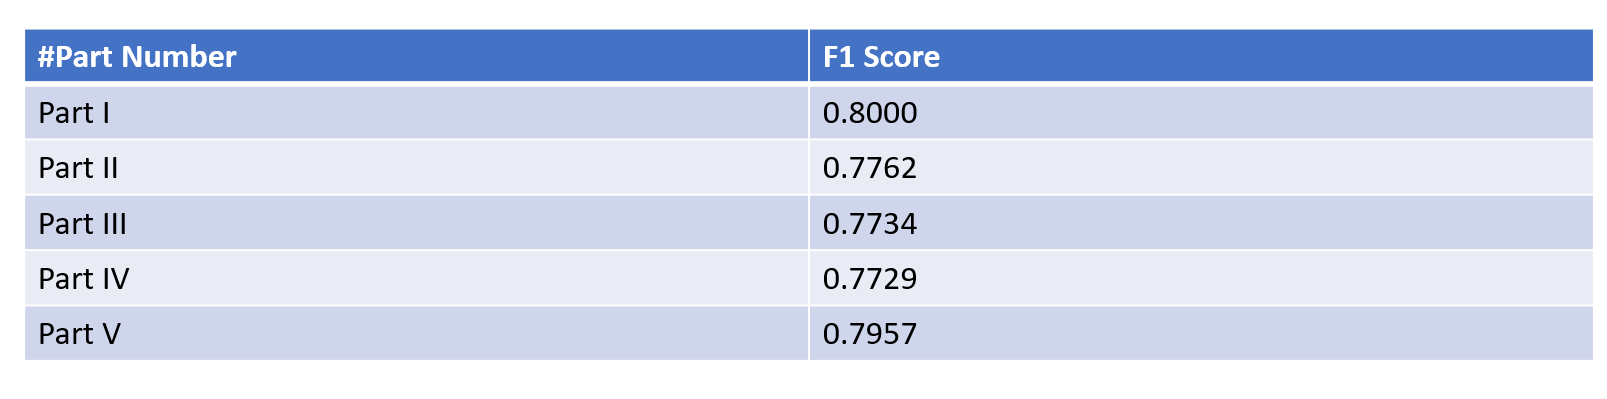

**In this Jupyter notebook, we test several things, we achieve a higher F1 score in part I but in part I overfitting condition is occurs and model time complexity is higher.<br> When we change the model in part II, we prevent the overfitting problem with the early stopping and dropout layer but our F1 score is decrease. <br>In part III doubling the MAX_SEQUENCE_LENGTH variable does not enhance the model. <br>In part 4 we try different model architectures with almost the same results with parts II and III.<br> Finally, we optimize the DOC2VEC model and embedding matrices in part V. Our F1 score is increased in noticeable value. In brief in our case, changing the model is not improve the accuracy but optimizing the DOC2VEC model increases the accuracy**